In [277]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [278]:
!ls pyWake/

b14-ss.nc             noj.nc                pywake_linear_bast.nc
b14.nc                pywake_FUGA.nc        zong.nc


In [279]:
!ls foxes/

power_validation_inputs_foxes_1.csv
power_validation_inputs_foxes_2.csv
power_validation_inputs_foxes_3.csv
power_validation_inputs_foxes_A.csv
power_validation_inputs_foxes_B.csv
power_validation_inputs_foxes_C.csv
power_validation_inputs_foxes_D.csv
power_validation_inputs_foxes_E.csv
power_validation_inputs_foxes_F.csv
power_validation_inputs_foxes_G.csv
turbine_data_validation_inputs_foxes_1.nc
turbine_data_validation_inputs_foxes_2.nc
turbine_data_validation_inputs_foxes_3.nc
turbine_data_validation_inputs_foxes_A.nc
turbine_data_validation_inputs_foxes_B.nc
turbine_data_validation_inputs_foxes_C.nc
turbine_data_validation_inputs_foxes_D.nc
turbine_data_validation_inputs_foxes_E.nc
turbine_data_validation_inputs_foxes_F.nc
turbine_data_validation_inputs_foxes_G.nc


In [280]:
!ls WAYVE/

power_windio_les_validation_wayve.csv


In [281]:
pywake_pred = [xr.load_dataset('pyWake/%s.nc' % ii) for ii in ['b14', 'b14-ss']]
#pywake_pred = [xr.load_dataset('pyWake/%s.nc' % ii) for ii in ['noj', 'b14', 'b14-ss']]

In [282]:
letters = ['1', '2', '3']
foxes_pred = [xr.load_dataset('foxes/turbine_data_validation_inputs_foxes_%s.nc' % letters[ii]) for ii in range(len(letters))]

In [283]:
wayve_dat = pd.read_csv('WAYVE/power_windio_les_validation_wayve.csv')

In [284]:
code_saturne_dat = pd.read_csv('code_saturne/power_validation_code_saturne.csv')
code_saturne_rho = pd.read_csv('code_saturne/Density_validation_code_saturne.csv')
##uncomment to try density correction
#rho_to_use = 1.225
#code_saturne_dat.values[:,1:] = rho_to_use*code_saturne_dat.values[:,1:]/code_saturne_rho.values[:,1:]

In [285]:
np.array([wayve_dat.iloc[0].values[1:].max(), code_saturne_dat.iloc[0].values[1:].max(), 1e3 * foxes_pred[0].isel(state=0).P.values.max(),  pywake_pred[0].isel(time=0).Power.values.max()]) / 1e6

array([9.19739901, 8.33665592, 9.38805978, 9.56215049])

In [286]:
case_num = 23
les_dat = pd.read_csv('LES/power_windio_les_validation.csv')


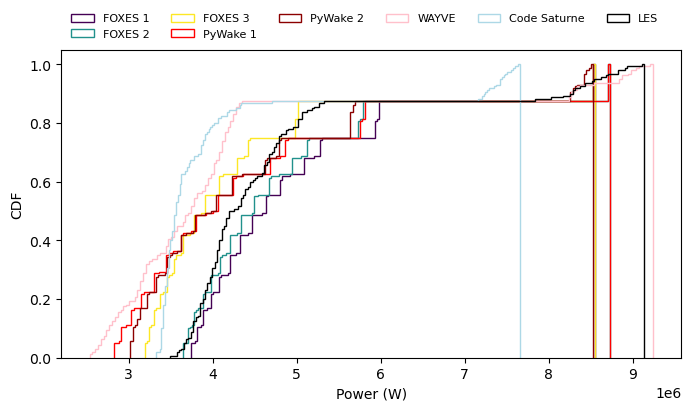

In [287]:
plt.subplots(figsize=(8, 4))

foxes_colors = plt.cm.viridis(np.linspace(0, 1, len(letters)))
pywake_colors = ['red', 'darkred', 'firebrick']

for ll in range(len(letters)):
    plt.hist(foxes_pred[ll].isel(state=case_num).P * 1e3, 200, density=True, cumulative=True, histtype='step', edgecolor=foxes_colors[ll], label='FOXES %s' % letters[ll])
for ll in range(len(pywake_pred)):
    plt.hist(pywake_pred[ll].isel(time=case_num).Power, 200, density=True, cumulative=True, histtype='step', edgecolor=pywake_colors[ll], label='PyWake %s' % letters[ll])
plt.hist(wayve_dat.iloc[case_num].values[1:], 200, cumulative=True, density=True, histtype='step', edgecolor='pink', label='WAYVE')
plt.hist(code_saturne_dat.iloc[case_num].values[1:], 200, density=True, cumulative=True, histtype='step', edgecolor='lightblue', label='Code Saturne')
#plt.hist(code_saturne_rho.iloc[case_num].values[1:], 200, density=True, cumulative=True, histtype='step', edgecolor='blue', label='Code Saturne rho')
plt.hist(les_dat.iloc[case_num].values[1:], 200, cumulative=True, density=True, histtype='step', edgecolor='k', label='LES')
plt.legend(ncol=6, prop={'size': 8}, loc='upper left', bbox_to_anchor=((0, 1.15)))
plt.xlabel("Power (W)")
plt.ylabel('CDF')
plt.savefig('CDFs.pdf')

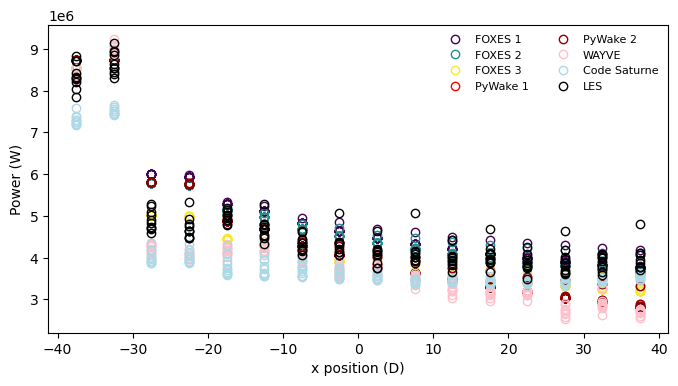

In [288]:
D = 198.0
x = np.array([-7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -495.0, -495.0, -495.0, -495.0, -495.0, -495.0, -495.0, -495.0, -495.0, -495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0]) / D
y = [-4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5]

plt.subplots(figsize=(8, 4))
case_num = 23
for ll in range(len(letters)):
    plt.plot(x, foxes_pred[ll].isel(state=case_num).P * 1e3, c=foxes_colors[ll], label='FOXES %s' % letters[ll], marker='o', fillstyle='none', lw=0)
for ll in range(2):
    plt.plot(x, pywake_pred[0].isel(time=case_num).Power, c=pywake_colors[ll], label='PyWake %s' % letters[ll], marker='o', fillstyle='none', lw=0)
plt.plot(x, wayve_dat.iloc[case_num].values[1:], c='pink', label='WAYVE', marker='o', fillstyle='none', lw=0)
plt.plot(x, code_saturne_dat.iloc[case_num].values[1:], c='lightblue', label='Code Saturne', marker='o', fillstyle='none', lw=0)
plt.plot(x, les_dat.iloc[case_num].values[1:], c='k', label='LES', marker='o', fillstyle='none', lw=0)
plt.legend(ncol=2, prop={'size': 8}, loc='upper right')
plt.xlabel("x position (D)")
plt.ylabel('Power (W)')
plt.savefig('Rows.pdf')

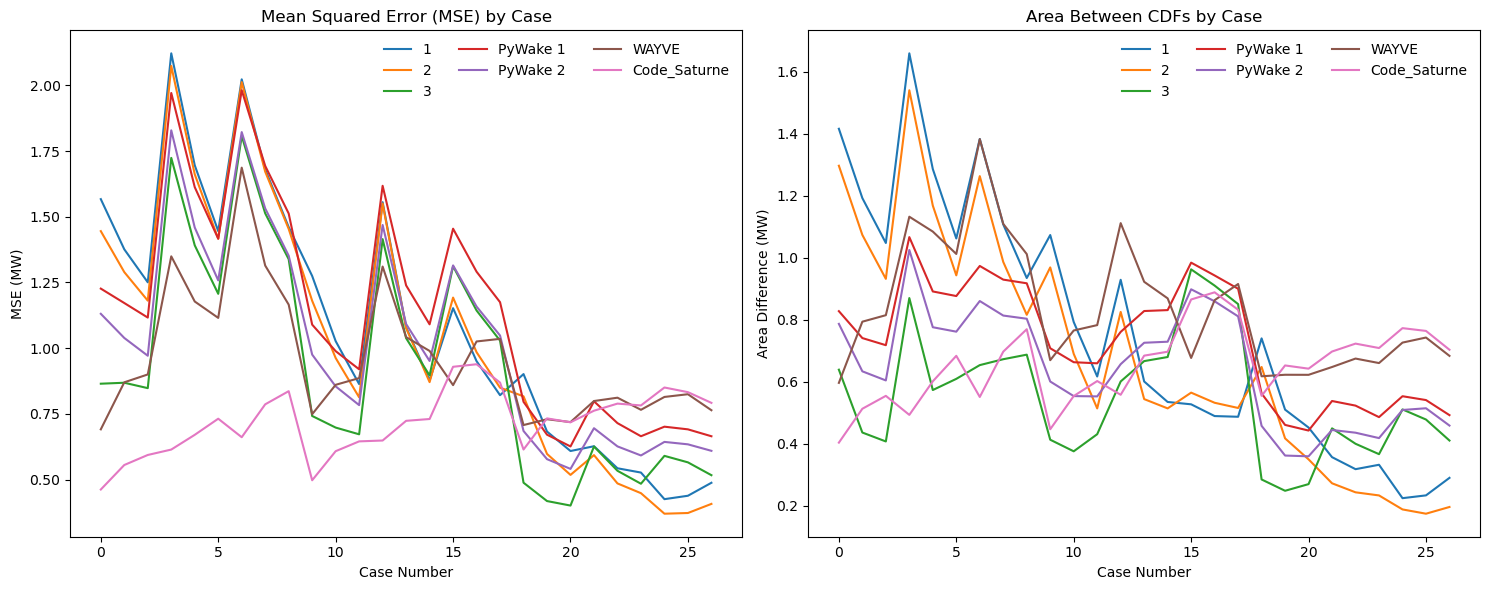

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


names = ['H300-C2-G1', 'H300-C2-G4', 'H300-C2-G8', 'H300-C5-G1', 'H300-C5-G4', 'H300-C5-G8', 'H300-C8-G1', 'H300-C8-G4', 'H300-C8-G8', 'H500-C2-G1', 'H500-C2-G4', 'H500-C2-G8', 'H500-C5-G1', 'H500-C5-G4', 'H500-C5-G8', 'H500-C8-G1', 'H500-C8-G4', 'H500-C8-G8', 'H1000-C2-G1', 'H1000-C2-G4', 'H1000-C2-G8', 'H1000-C5-G1', 'H1000-C5-G4', 'H1000-C5-G8', 'H1000-C8-G1', 'H1000-C8-G4', 'H1000-C8-G8']
Hs, Cs, Gs = [], [], []
for ll in range(len(names)):
    name = names[ll].split('-')
    Hs.append(int(name[0][1:]))
    Cs.append(int(name[1][1:]))
    Gs.append(int(name[2][1:]))
    
# Number of cases
num_cases = 27

# Initialize lists for storing metrics
mse_values = {letter: [] for letter in letters}
mse_values['PyWake 1'] = []
mse_values['PyWake 2'] = []
mse_values['WAYVE'] = []
mse_values['Code_Saturne'] = []

area_diff_values = {letter: [] for letter in letters}
area_diff_values['PyWake 1'] = []
area_diff_values['PyWake 2'] = []
area_diff_values['WAYVE'] = []
area_diff_values['Code_Saturne'] = []

# Common grid for CDF
common_grid = np.linspace(0, 1.3e7, 1000)  # Example range, adjust as needed

# Function to calculate area between CDFs
def area_between_cdfs(data1, data2, grid):
    cdf1 = np.interp(grid, np.sort(data1), np.linspace(0, 1, len(data1)))
    cdf2 = np.interp(grid, np.sort(data2), np.linspace(0, 1, len(data2)))
    return np.trapz(np.abs(cdf1 - cdf2), grid) / 1e6

# Calculating MSE and area between CDFs for each case
for case_num in range(num_cases):
    les_case_values = les_dat.iloc[case_num].values[1:]

    # FOXES models
    for ll, letter in enumerate(letters):
        foxes_values = foxes_pred[ll].isel(state=case_num).P.values * 1e3
        mse = np.sqrt(np.mean((foxes_values - les_case_values) ** 2)) / 1e6
        mse_values[letter].append(mse)
        area_diff = area_between_cdfs(foxes_values, les_case_values, common_grid)
        area_diff_values[letter].append(area_diff)

    # PyWake Blockage
    pywake_blockage_values = pywake_pred[1].isel(time=case_num).Power.values
    mse = np.sqrt(np.mean((pywake_blockage_values - les_case_values) ** 2)) / 1e6
    mse_values['PyWake 2'].append(mse)
    area_diff = area_between_cdfs(pywake_blockage_values, les_case_values, common_grid)
    area_diff_values['PyWake 2'].append(area_diff)

    # PyWake No Blockage
    pywake_no_blockage_values = pywake_pred[0].isel(time=case_num).Power.values
    mse = np.sqrt(np.mean((pywake_no_blockage_values - les_case_values) ** 2)) / 1e6
    mse_values['PyWake 1'].append(mse)
    area_diff = area_between_cdfs(pywake_no_blockage_values, les_case_values, common_grid)
    area_diff_values['PyWake 1'].append(area_diff)

    # Code_Saturne
    saturne_values = code_saturne_dat.iloc[case_num].values[1:]
    mse = np.sqrt(np.mean((saturne_values - les_case_values) ** 2)) / 1e6
    mse_values['Code_Saturne'].append(mse)
    area_diff = area_between_cdfs(saturne_values, les_case_values, common_grid)
    area_diff_values['Code_Saturne'].append(area_diff)
    
    # WAYVE
    wayve_values = wayve_dat.iloc[case_num].values[1:]
    mse = np.sqrt(np.mean((wayve_values - les_case_values) ** 2)) / 1e6
    mse_values['WAYVE'].append(mse)
    area_diff = area_between_cdfs(wayve_values, les_case_values, common_grid)
    area_diff_values['WAYVE'].append(area_diff)

# Plotting the results
plt.figure(figsize=(15, 6))

# MSE plot
plt.subplot(1, 2, 1)
for key, value in mse_values.items():
    plt.plot(range(num_cases), value, label=key)
plt.title('Mean Squared Error (MSE) by Case')
plt.xlabel('Case Number')
plt.ylabel('MSE (MW)')
plt.legend(ncol=3)

# Area between CDFs plot
plt.subplot(1,2, 2)
for key, value in area_diff_values.items():
    plt.plot(range(num_cases), value, label=key)
plt.title('Area Between CDFs by Case')
plt.xlabel('Case Number')
plt.ylabel('Area Difference (MW)')
plt.legend(ncol=3)

plt.tight_layout()
plt.show()


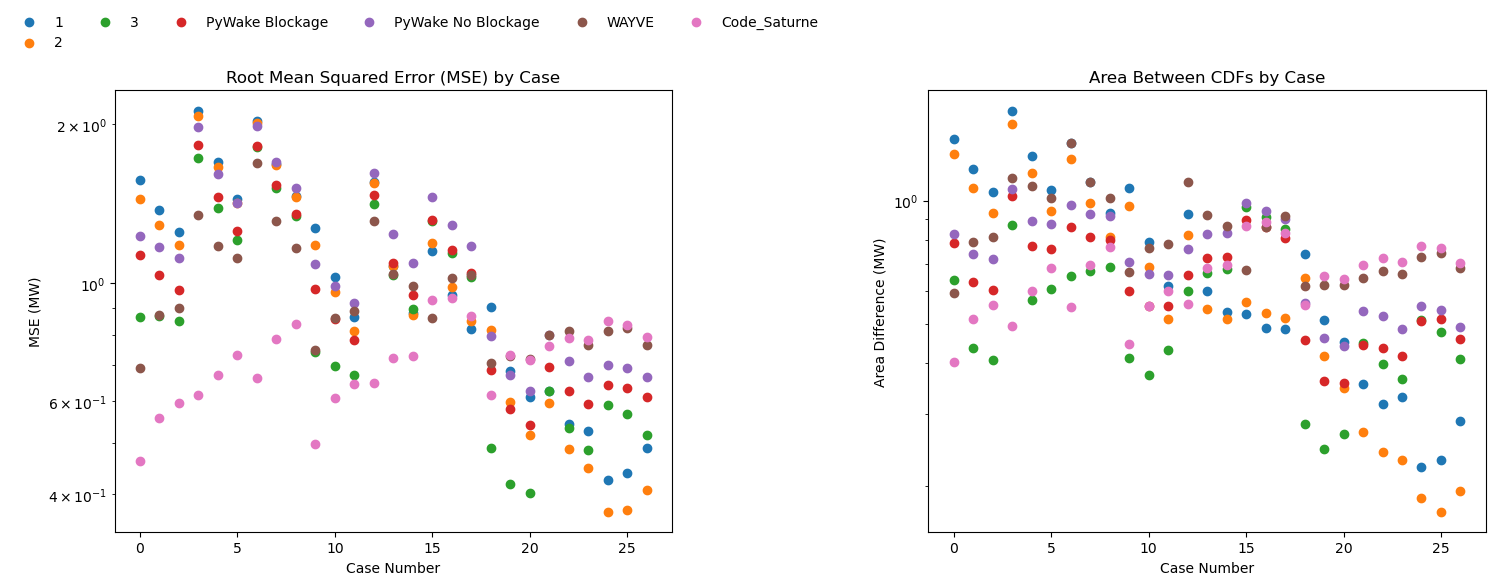

In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


names = ['H300-C2-G1', 'H300-C2-G4', 'H300-C2-G8', 'H300-C5-G1', 'H300-C5-G4', 'H300-C5-G8', 'H300-C8-G1', 'H300-C8-G4', 'H300-C8-G8', 'H500-C2-G1', 'H500-C2-G4', 'H500-C2-G8', 'H500-C5-G1', 'H500-C5-G4', 'H500-C5-G8', 'H500-C8-G1', 'H500-C8-G4', 'H500-C8-G8', 'H1000-C2-G1', 'H1000-C2-G4', 'H1000-C2-G8', 'H1000-C5-G1', 'H1000-C5-G4', 'H1000-C5-G8', 'H1000-C8-G1', 'H1000-C8-G4', 'H1000-C8-G8']
Hs, Cs, Gs = [], [], []
for ll in range(len(names)):
    name = names[ll].split('-')
    Hs.append(int(name[0][1:]))
    Cs.append(int(name[1][1:]))
    Gs.append(int(name[2][1:]))
    
# Number of cases
num_cases = 27

# Initialize lists for storing metrics
mse_values = {letter: [] for letter in letters}
mse_values['PyWake Blockage'] = []
mse_values['PyWake No Blockage'] = []
mse_values['WAYVE'] = []
mse_values['Code_Saturne'] = []

area_diff_values = {letter: [] for letter in letters}
area_diff_values['PyWake Blockage'] = []
area_diff_values['PyWake No Blockage'] = []
area_diff_values['WAYVE'] = []
area_diff_values['Code_Saturne'] = []

# Common grid for CDF
common_grid = np.linspace(0, 1.3e7, 1000)  # Example range, adjust as needed

# Function to calculate area between CDFs
def area_between_cdfs(data1, data2, grid):
    cdf1 = np.interp(grid, np.sort(data1), np.linspace(0, 1, len(data1)))
    cdf2 = np.interp(grid, np.sort(data2), np.linspace(0, 1, len(data2)))
    return np.trapz(np.abs(cdf1 - cdf2), grid) / 1e6

# Calculating MSE and area between CDFs for each case
for case_num in range(num_cases):
    les_case_values = les_dat.iloc[case_num].values[1:]

    # FOXES models
    for ll, letter in enumerate(letters):
        foxes_values = foxes_pred[ll].isel(state=case_num).P.values * 1e3
        mse = np.sqrt(np.mean((foxes_values - les_case_values) ** 2)) / 1e6
        mse_values[letter].append(mse)
        area_diff = area_between_cdfs(foxes_values, les_case_values, common_grid)
        area_diff_values[letter].append(area_diff)

    # PyWake Blockage
    pywake_blockage_values = pywake_pred[1].isel(time=case_num).Power.values
    mse = np.sqrt(np.mean((pywake_blockage_values - les_case_values) ** 2)) / 1e6
    mse_values['PyWake Blockage'].append(mse)
    area_diff = area_between_cdfs(pywake_blockage_values, les_case_values, common_grid)
    area_diff_values['PyWake Blockage'].append(area_diff)

    # PyWake No Blockage
    pywake_no_blockage_values = pywake_pred[0].isel(time=case_num).Power.values
    mse = np.sqrt(np.mean((pywake_no_blockage_values - les_case_values) ** 2)) / 1e6
    mse_values['PyWake No Blockage'].append(mse)
    area_diff = area_between_cdfs(pywake_no_blockage_values, les_case_values, common_grid)
    area_diff_values['PyWake No Blockage'].append(area_diff)

    # Code_Saturne
    saturne_values = code_saturne_dat.iloc[case_num].values[1:]
    mse = np.sqrt(np.mean((saturne_values - les_case_values) ** 2)) / 1e6
    mse_values['Code_Saturne'].append(mse)
    area_diff = area_between_cdfs(saturne_values, les_case_values, common_grid)
    area_diff_values['Code_Saturne'].append(area_diff)
    
    # WAYVE
    wayve_values = wayve_dat.iloc[case_num].values[1:]
    mse = np.sqrt(np.mean((wayve_values - les_case_values) ** 2)) / 1e6
    mse_values['WAYVE'].append(mse)
    area_diff = area_between_cdfs(wayve_values, les_case_values, common_grid)
    area_diff_values['WAYVE'].append(area_diff)

# Plotting the results
plt.figure(figsize=(15, 6))

# MSE plot
plt.subplot(1, 2, 1)
for key, value in mse_values.items():
    plt.scatter(range(len(Cs)), value, label=key)
plt.title('Root Mean Squared Error (MSE) by Case')
plt.xlabel('Case Number')
plt.ylabel('MSE (MW)')
plt.yscale('log')
plt.legend(ncol=6, loc='upper left', bbox_to_anchor=(-0.2, 1.2))

# Area between CDFs plot
plt.subplot(1,2, 2)
for key, value in area_diff_values.items():
    plt.scatter(range(len(Cs)), value, label=key)
plt.title('Area Between CDFs by Case')
plt.xlabel('Case Number')
plt.ylabel('Area Difference (MW)')
#plt.legend(ncol=3)
plt.yscale('log')
plt.tight_layout()
plt.show()


RMSE Proj [-0.02776429  0.18290385 -0.98273869]
Area Proj [-0.02121404 -0.61173334 -0.79077954]


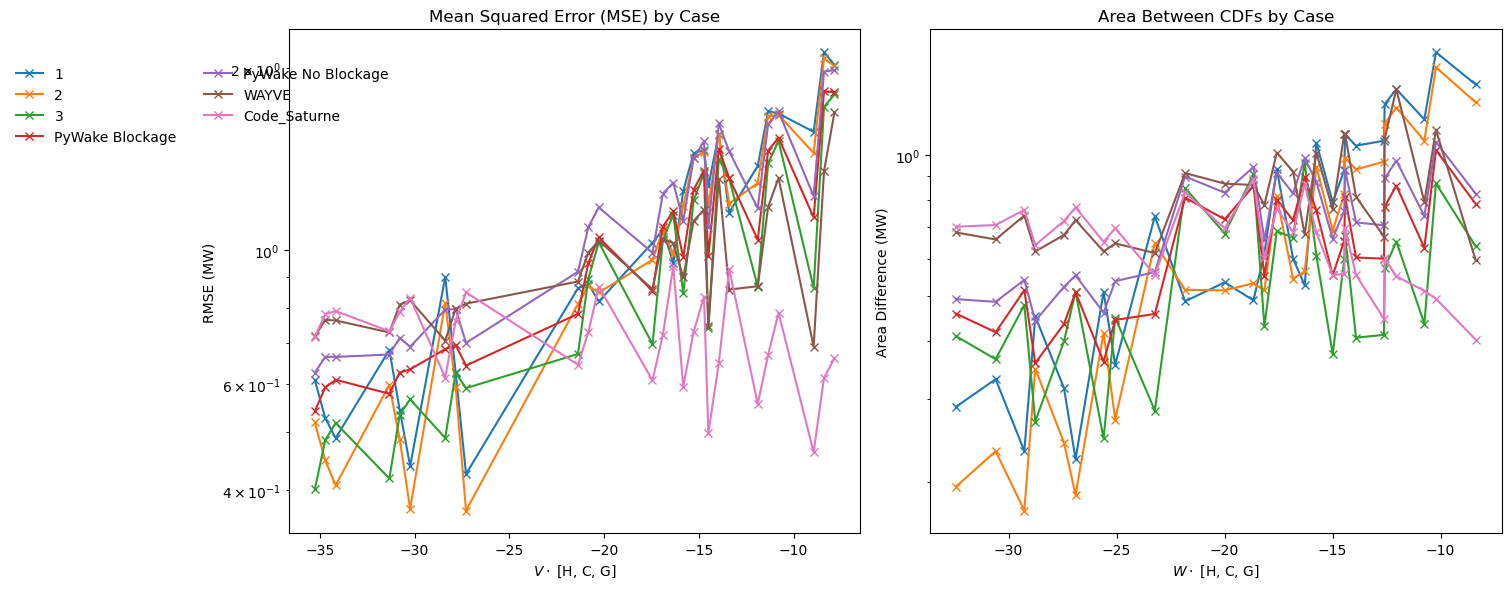

In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


# Convert Hs, Cs, Gs to a numpy array for regression
X = np.array([Hs, Cs, Gs]).T

# Combine all MSE values across models into a single array
#Y_mse_all = np.concatenate([mse_values[model] for model in mse_values])
Y_mse_all = np.concatenate([mse_values[model] for model in ['2']])

# Combine all area difference values across models into a single array
Y_area_diff_all = np.concatenate([area_diff_values[model] for model in ['2']])

# Prepare extended X arrays for regression (one for each error metric)
X_extended_mse = X #np.repeat(X, len(mse_values), axis=0)
X_extended_area_diff = X # np.repeat(X, len(area_diff_values), axis=0)

# Perform linear regression for the combined MSE dataset
reg_mse = LinearRegression().fit(X_extended_mse, Y_mse_all)
a_mse = reg_mse.coef_
b_mse = reg_mse.intercept_

# Perform linear regression for the combined area differences dataset
reg_area_diff = LinearRegression().fit(X_extended_area_diff, Y_area_diff_all)
a_area_diff = reg_area_diff.coef_
b_area_diff = reg_area_diff.intercept_

a_mse /= np.sqrt((a_mse ** 2).sum())
a_area_diff /= np.sqrt((a_area_diff ** 2).sum())
print('RMSE Proj', a_mse)
print('Area Proj', a_area_diff)
projected_rmse = np.dot(a_mse, X.T)
projected_area = np.dot(a_area_diff, X.T)
#projected_area /= np.sqrt(np.sum(projected_area **2 ))
#projected_rmse /= np.sqrt(np.sum(projected_rmse **2 ))

# Plotting the results
plt.figure(figsize=(15, 6))
idx = np.argsort(projected_rmse)

# MSE plot
plt.subplot(1, 2, 1)
for key, value in mse_values.items():
    plt.plot(projected_rmse[idx], np.array(value)[idx], label=key, marker='x')
plt.title('Mean Squared Error (MSE) by Case')
plt.xlabel('$V\cdot$ [H, C, G]')
plt.ylabel('RMSE (MW)')
plt.yscale('log')
plt.legend(ncol=2, loc='upper left', bbox_to_anchor=(-0.5, 0.95))

idx = np.argsort(projected_area)
# Area between CDFs plot
plt.subplot(1,2, 2)
for key, value in area_diff_values.items():
    plt.plot(projected_area[idx], np.array(value)[idx], label=key, marker='x')
plt.title('Area Between CDFs by Case')
plt.xlabel('$W\cdot$ [H, C, G]')
plt.ylabel('Area Difference (MW)')
#plt.legend(ncol=3)
plt.yscale('log')
plt.tight_layout()
plt.savefig('Projections.pdf')

RMSE Proj [-0.02776429  0.18290385 -0.98273869]
Area Proj [-0.02121404 -0.61173334 -0.79077954]


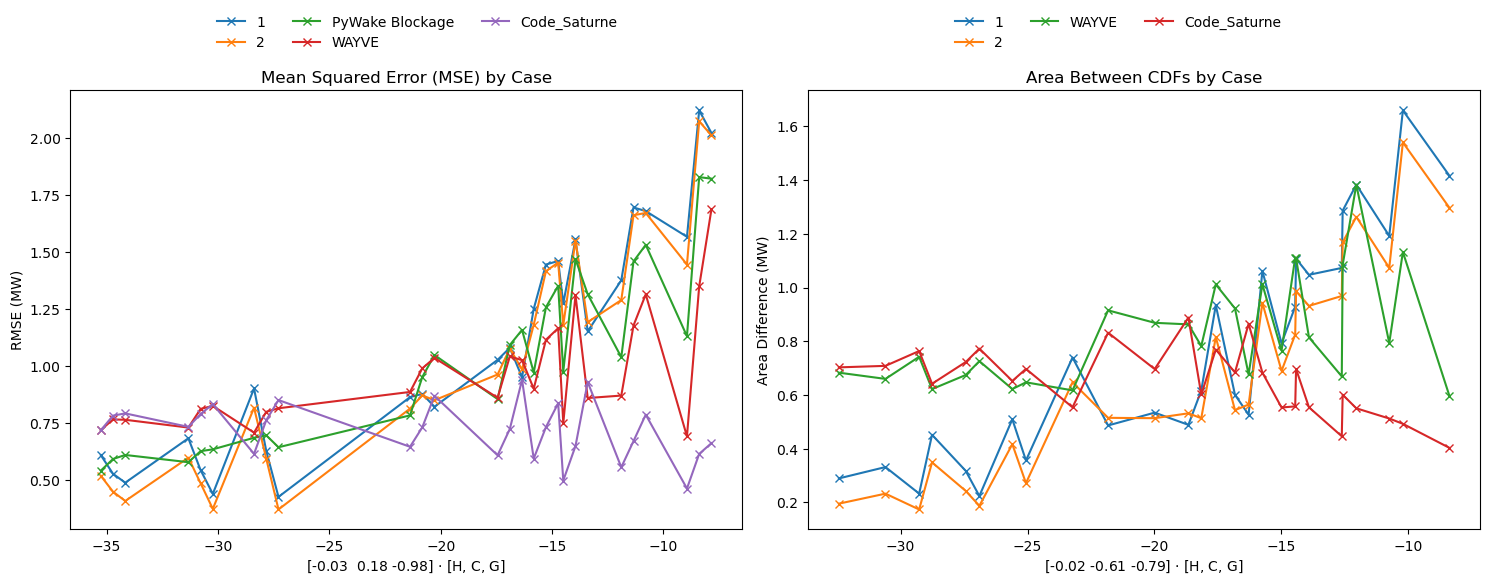

In [292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Convert Hs, Cs, Gs to a numpy array for regression
X = np.array([Hs, Cs, Gs]).T

# Combine all MSE values across models into a single array
#Y_mse_all = np.concatenate([mse_values[model] for model in mse_values])
Y_mse_all = np.concatenate([mse_values[model] for model in ['2']])

# Combine all area difference values across models into a single array
Y_area_diff_all = np.concatenate([area_diff_values[model] for model in ['2']])

# Prepare extended X arrays for regression (one for each error metric)
X_extended_mse = X #np.repeat(X, len(mse_values), axis=0)
X_extended_area_diff = X # np.repeat(X, len(area_diff_values), axis=0)

# Perform linear regression for the combined MSE dataset
reg_mse = LinearRegression().fit(X_extended_mse, Y_mse_all)
a_mse = reg_mse.coef_
b_mse = reg_mse.intercept_

# Perform linear regression for the combined area differences dataset
reg_area_diff = LinearRegression().fit(X_extended_area_diff, Y_area_diff_all)
a_area_diff = reg_area_diff.coef_
b_area_diff = reg_area_diff.intercept_

a_mse /= np.sqrt((a_mse ** 2).sum())
a_area_diff /= np.sqrt((a_area_diff ** 2).sum())
print('RMSE Proj', a_mse)
print('Area Proj', a_area_diff)
projected_rmse = np.dot(a_mse, X.T)
projected_area = np.dot(a_area_diff, X.T)
#projected_area /= np.sqrt(np.sum(projected_area **2 ))
#projected_rmse /= np.sqrt(np.sum(projected_rmse **2 ))

# Plotting the results
plt.figure(figsize=(15, 6))
idx = np.argsort(projected_rmse)

# MSE plot
plt.subplot(1, 2, 1)
for key, value in mse_values.items():
    if key in ['1', '2', 'PyWake Blockage', 'PyWake 2', 'WAYVE', 'Code_Saturne']:
        plt.plot(projected_rmse[idx], np.array(value)[idx], label=key, marker='x')
plt.title('Mean Squared Error (MSE) by Case')
plt.xlabel('%s $\cdot$ [H, C, G]' % np.round(a_mse, 2))
plt.ylabel('RMSE (MW)')
#plt.yscale('log')
plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(0.2, 1.2))

idx = np.argsort(projected_area)
# Area between CDFs plot
plt.subplot(1,2, 2)
for key, value in area_diff_values.items():
    if key in ['1', '2', 'PyWake 1', 'PyWake 2', 'WAYVE', 'Code_Saturne']:
        plt.plot(projected_area[idx], np.array(value)[idx], label=key, marker='x')
plt.title('Area Between CDFs by Case')
plt.xlabel('%s $\cdot$ [H, C, G]' % np.round(a_area_diff, 2))
plt.ylabel('Area Difference (MW)')
plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(0.2, 1.2))
#plt.legend(ncol=3)
#plt.yscale('log')
plt.tight_layout()
plt.savefig('Projections_less.pdf')

In [293]:
means

[0.7624181579023092,
 0.6813762716529891,
 0.5496894415003141,
 0.6443556710184498,
 0.7335545080749516,
 0.8333542043999316,
 0.651843055901864]

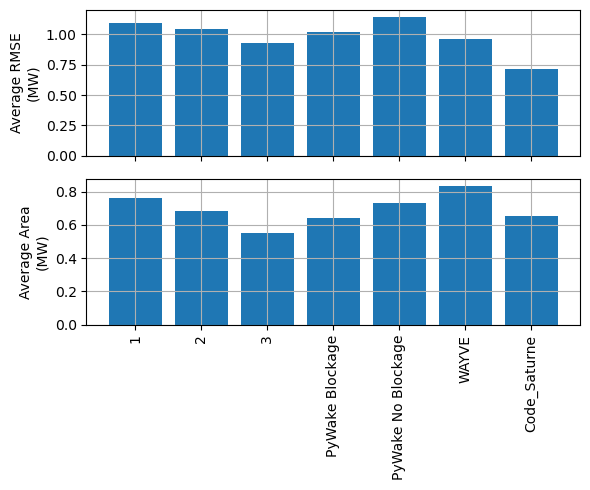

In [294]:
fig, ax = plt.subplots(2, figsize=(6, 5), sharex=True)


means = []
models = []
for key, value in mse_values.items():
    means.append(np.mean(value))
    models.append(key)
    
# models[-4] = 'PyWake\nFUGA'
# models[-3] = 'PyWake'
ax[0].bar(range(len(models)), means)

    
means = []
for key, value in area_diff_values.items():
    means.append(np.mean(value))
    #models.append(key)
ax[1].bar(range(len(models)), means)

ax[0].set_ylabel("Average RMSE\n(MW)")
ax[1].set_ylabel("Average Area\n(MW)")

ax[1].set_xticks(range(len(models)))
ax[1].set_xticklabels(models, rotation=90)
ax[0].grid('y')
ax[1].grid('y')
plt.tight_layout()
plt.savefig('Bars.pdf')

In [295]:
models

['1',
 '2',
 '3',
 'PyWake Blockage',
 'PyWake No Blockage',
 'WAYVE',
 'Code_Saturne']

In [296]:
np.array(value)[idx]

array([0.70272497, 0.70831927, 0.76353488, 0.64167745, 0.7225559 ,
       0.77249987, 0.65210974, 0.69703979, 0.55398801, 0.8318296 ,
       0.69639544, 0.88812273, 0.60170969, 0.76898469, 0.68374395,
       0.86504386, 0.68311785, 0.55332053, 0.55742468, 0.69665483,
       0.55393273, 0.44616123, 0.60083555, 0.55030446, 0.51228415,
       0.49253279, 0.40291386])

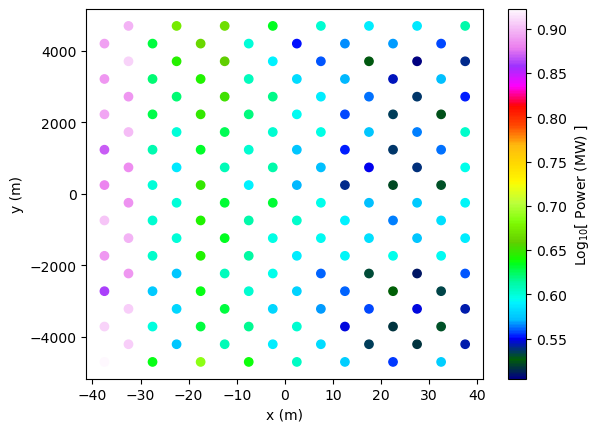

In [297]:
case_num = 18

# x = [-7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -7425.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -6435.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -5445.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -4455.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -3465.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -2475.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -1485.0, -495.0, -495.0, -495.0, -495.0, -495.0, -495.0, -495.0, -495.0, -495.0, -495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 495.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 1485.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 2475.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 3465.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 4455.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 5445.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 6435.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0, 7425.0]
# y = [-4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5, -4702.5, -3712.5, -2722.5, -1732.5, -742.5, 247.5, 1237.5, 2227.5, 3217.5, 4207.5, -4207.5, -3217.5, -2227.5, -1237.5, -247.5, 742.5, 1732.5, 2722.5, 3712.5, 4702.5]
plt.scatter(x, y, c=np.log10(les_dat.iloc[case_num].values[1:] / 1e6), cmap=plt.cm.gist_ncar)
cb = plt.colorbar()
cb.set_label('Log$_{10}$[ Power (MW) ]')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.savefig('LES_viz.pdf')